In [0]:
%cd /content
from IPython.display import clear_output
#!git clone https://github.com/jmestanza/time_stretching.git

#imports
#!pip install librosa
!pip install webrtcvad
import webrtcvad
!pip install --upgrade librosa
import librosa 
import scipy
import numpy as np
from IPython.display import Audio

clear_output()

In [0]:
#local modules
!wget https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/detect_pitch.py
!wget https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/modified_psola.py
!wget https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/vad.py

from modified_psola import modified_psola
from detect_pitch import get_fundamental_frequency
from vad import float2pcm, pcm2float, frame_generator, join_vad_frames, get_vad_frames
from vad import Frame


#audios
!wget "https://raw.githubusercontent.com/vicaub/Pitch-Estimation-and-Voicing-Detection/master/data/fda_ue/rl047.wav"
!wget "https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/input/shh.wav"

clear_output()

In [3]:
fs = 48000

audio_file = "/content/rl047.wav"
test, _ = librosa.load(audio_file, sr=fs, mono=True)
audio_int = float2pcm(test, dtype="int32")

#test para no-sonoro
audio_file2 = "/content/shh.wav"
unvoiced, _ = librosa.load(audio_file2, sr=fs, mono=True)
unvoiced = float2pcm(unvoiced, dtype="int32")
out_pcm = np.concatenate((audio_int,unvoiced))

# necesito al menos dos periodos de la señal
#200 = (50+25)+50+(50+25)
#L = 50 # muestras de la ventana
#K = L//2
# tamaño total por observacion
# total = 4*L

#quiero tener 20 milisegundos de señal
T = 20*1e-3
samples = int(T * fs) 
L = samples//4
K = L

Audio(data=out_pcm, rate=fs)

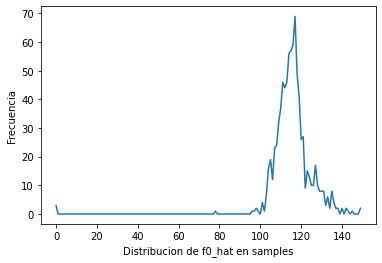

360


In [4]:
import matplotlib.pyplot as plt

vad = webrtcvad.Vad(3)    #0 is the least aggressive about filtering out non-speech, 3 is the most aggressive; 3 pone mas frames en no-sonoros

#divido el audio en frames de 20 milisegundos
frames = frame_generator(20, out_pcm, fs)
frames = list(frames)

speech, not_speech, is_frame_speech, frame_len = get_vad_frames(frames, vad, fs)
speed = 2.0

audio = pcm2float(sig=out_pcm)

regions = []
for i in range(len(is_frame_speech)):
  if i == len(is_frame_speech) - 1:
    regions.append([start,i])
  elif i ==0:
    start = 0
  else:
    curr_region = is_frame_speech[i] # si es sonoro o no sonoro
    if curr_region != is_frame_speech[i-1]:
      regions.append([start,i-1]) # pusheo la region anterior
      start = i


lpc_coeffs = []
error = []
for start, end in regions:
  a = librosa.lpc(audio[start:end], 12)
  lpc_coeffs.append(a)
  error.extend(scipy.signal.lfilter(a, [1], audio[start:end]))

error = np.array(error)

indexes,sample_f0 = get_fundamental_frequency(error,is_frame_speech, K, L, fs)
mean_f0_samples = np.mean(sample_f0)

voiced_audio = modified_psola(error, indexes, sample_f0, speed, is_frame_speech, regions)

voiced_filt = []
from math import ceil 
for i,reg in enumerate(regions):
  start,end = reg
  start = ceil(start*(1/speed))
  end = ceil(end*(1/speed))
  voiced_filt.extend(scipy.signal.lfilter([1], lpc_coeffs[i] , voiced_audio[start:end]))

voiced_filt = np.array(voiced_filt)
Audio(data=voiced_filt, rate=fs)
